In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [8]:
from os import listdir
from os.path import join
from nltk import word_tokenize
import pickle
import pandas as pd

In [9]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 90000

In [10]:
# Fetch stopwords
with open('/home/user/project/stopw.txt', 'r') as f:
    stopw = f.read()
f.closed
stopw = stopw.replace('\n',' ').split()

In [11]:
stopw[:5]

['αδιακοπα', 'αι', 'ακομα', 'ακομη', 'ακριβως']

In [12]:
def build_dataset(words, vocabulary_size, author_name):
    count = []
    # remove stressing and to lower
    words = [w.lower().replace('»','').replace('«', '').replace('-','').replace('ώ','ω')\
                  .replace('ά','α').replace('έ','ε').replace('ή','η').replace('ί','ι').replace('ό','ο')\
                  .replace('ύ','υ').replace('(','').replace(')','') for w in words]
    # exclude stopwords
    words = [token for token in words if token not in stopw]
    #print('Words after stopwords removal: {}'.format(len(words)))
    
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))

    for word, _ in count:
        if word not in dictionary and len(dictionary) < vocabulary_size:
            dictionary[word] = len(dictionary)
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
            data.append([authors[author_name],index])     
    return count

In [13]:
def read_author(file, path):
    words = []
    # we get author_name directly from filename
    author_name = file[:-2]
    dictionary[author_name] = len(dictionary)
    # keep author index in a separate dictionary
    authors[author_name] = dictionary[author_name]

    pic = pickle.load(open(join(path, file),'rb'))
    df = pd.DataFrame(pic)
    #for a in df['article'].iloc[:500]:            # keep only first 500 articles
    for a in df['article']:                        # all articles
        tokens = word_tokenize(a)
        words.extend(tokens)
    print('Words in articles of {}: {}'.format(author_name,len(words)))
    return words, author_name

In [14]:
root = '/home/user/project/data/data/'
authors = dict()
dictionary = dict()
data = list()
# read all available newspapers
for news in listdir(root):
    path = join(root,news)
# read all authors
    for file in listdir(path):
        words, author_name = read_author(file, path)
        count = build_dataset(words, vocabulary_size, author_name)
        
        del words  # Hint to reduce memory.
        print("Data size after {}'s articles: {}".format(author_name, len(data)))
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
reverse_authors = dict(zip(authors.values(), authors.keys()))
print(authors)

Words in articles of zoulas: 75129
Data size after zoulas's articles: 41280
Words in articles of galiatsou: 70705
Data size after galiatsou's articles: 80860
Words in articles of nedou: 84281
Data size after nedou's articles: 129251
Words in articles of lakasas: 103867
Data size after lakasas's articles: 190724
Words in articles of mpistika: 107331
Data size after mpistika's articles: 254917
Words in articles of mpoukalas: 92743
Data size after mpoukalas's articles: 305068
Words in articles of liaggou: 95199
Data size after liaggou's articles: 361040
Words in articles of kleftogianni: 889308
Data size after kleftogianni's articles: 872545
Words in articles of giannikos: 189796
Data size after giannikos's articles: 983875
Words in articles of tzedakis: 711069
Data size after tzedakis's articles: 1403293
Words in articles of spyrakis: 75780
Data size after spyrakis's articles: 1441994
Words in articles of triantis: 178386
Data size after triantis's articles: 1536333
Words in articles of 

In [15]:
# could be slightly bigger than voabulary_size since we have to put all authors in it
len(dictionary.keys())

90013

In [16]:
for i in xrange(22):
    print(reverse_dictionary[i])

zoulas
,
.
κ.

πασοκ
δημαρ
κυβερνηση
παπανδρεου
γ.
ειπε
μονον
...
δυο
κουβελη
βουλευτες
περιπτωση
κυβερνησης
κομμα
στελεχη
εκ
ν.δ


In [17]:
# Step 3: Function to generate a training batch for author2vec model.

def generate_batch_author(batch_size):
    global data_index
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # just return the correct tuples from data
    for i in range(batch_size):
        batch[i] = data[data_index][1]
        labels[i, 0] = data[data_index][0]
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [18]:
len(data)

3697025

In [21]:
# test output of batch
data_index = 0
batch, labels = generate_batch_author(batch_size=128)
for i in range(128):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

61 πρωτη -> 0 zoulas
103 φορα -> 0 zoulas
22 πρωθυπουργος -> 0 zoulas
344 παραδεχθηκε -> 0 zoulas
410 αναγκαιο -> 0 zoulas
984 σφαλμα -> 0 zoulas
17 κυβερνησης -> 0 zoulas
704 αυξηση -> 0 zoulas
2687 φορολογηση -> 0 zoulas
1909 επιχειρησεων -> 0 zoulas
2 . -> 0 zoulas
411 μιλωντας -> 0 zoulas
1478 εκπροσωπους -> 0 zoulas
1479 συνδεσμου -> 0 zoulas
4460 εξαγωγεων -> 0 zoulas
3 κ. -> 0 zoulas
9 γ. -> 0 zoulas
8 παπανδρεου -> 0 zoulas
10 ειπε -> 0 zoulas
262 συγκεκριμενα -> 0 zoulas
1191 εποχη -> 0 zoulas
190 επρεπε -> 0 zoulas
4  -> 0 zoulas
12 ... -> 0 zoulas
4  -> 0 zoulas
4461 μειωνουμε -> 0 zoulas
1192 φορους -> 0 zoulas
1 , -> 0 zoulas
4462 ελλειμματων -> 0 zoulas
377 χρεους -> 0 zoulas
4463 βρηκαμε -> 0 zoulas
4464 αναγκασμενοι -> 0 zoulas
4465 ανεβασουμε -> 0 zoulas
2 . -> 0 zoulas
345 στοχος -> 0 zoulas
4466 διευρυνουμε -> 0 zoulas
1480 φορολογικη -> 0 zoulas
317 βαση -> 0 zoulas
818 μπορουμε -> 0 zoulas
4467 μειωσουμε -> 0 zoulas
1192 φορους -> 0 zoulas
4468 βοηθησουμε -> 0 zoul

In [22]:
# Due to adding author names to our dictionary, we may have some more records than vocabulary_size 
vocabulary_size = len(dictionary.keys())

In [23]:
# Step 4: Build and train a skip-gram model.

batch_size = 200
embedding_size = 200  # Dimension of the embedding vector.
skip_window = 5       # How many words to consider left and right.
num_skips = 1         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.
authors_size = len(authors.keys())

In [24]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
    stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    #
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    #
    # Add variable initializer.
    # init = tf.initialize_all_variables()
    init = tf.global_variables_initializer()

In [25]:
# Step 5: Begin training.
data_index = 0
num_steps = 74001
epoch = 0
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config,graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")
    #
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch_author(batch_size)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        #
        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        #
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
           # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        #
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            print('Epoch {} just finished!'.format(epoch))
            epoch += 1
        '''    sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 5  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
        '''
    final_embeddings = normalized_embeddings.eval()



Initialized
Average loss at step  0 :  296.47555542
Epoch 0 just finished!
Average loss at step  2000 :  150.639085377
Average loss at step  4000 :  84.3792411175
Average loss at step  6000 :  53.2924619958
Average loss at step  8000 :  36.6564685053
Average loss at step  10000 :  27.3893336042
Average loss at step  12000 :  21.2217069631
Average loss at step  14000 :  16.0001753168
Average loss at step  16000 :  13.1503462368
Average loss at step  18000 :  10.4743250583
Average loss at step  20000 :  11.9084760104
Epoch 1 just finished!
Average loss at step  22000 :  10.151007468
Average loss at step  24000 :  6.99746222045
Average loss at step  26000 :  4.03354889518
Average loss at step  28000 :  3.60154453455
Average loss at step  30000 :  2.95213006517
Average loss at step  32000 :  2.22306897093
Average loss at step  34000 :  1.98823221155
Average loss at step  36000 :  1.66820827665
Average loss at step  38000 :  2.6071645066
Average loss at step  40000 :  3.07447603154
Epoch 2 

In [26]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.savefig(filename)

/home/user/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Populating the interactive namespace from numpy and matplotlib


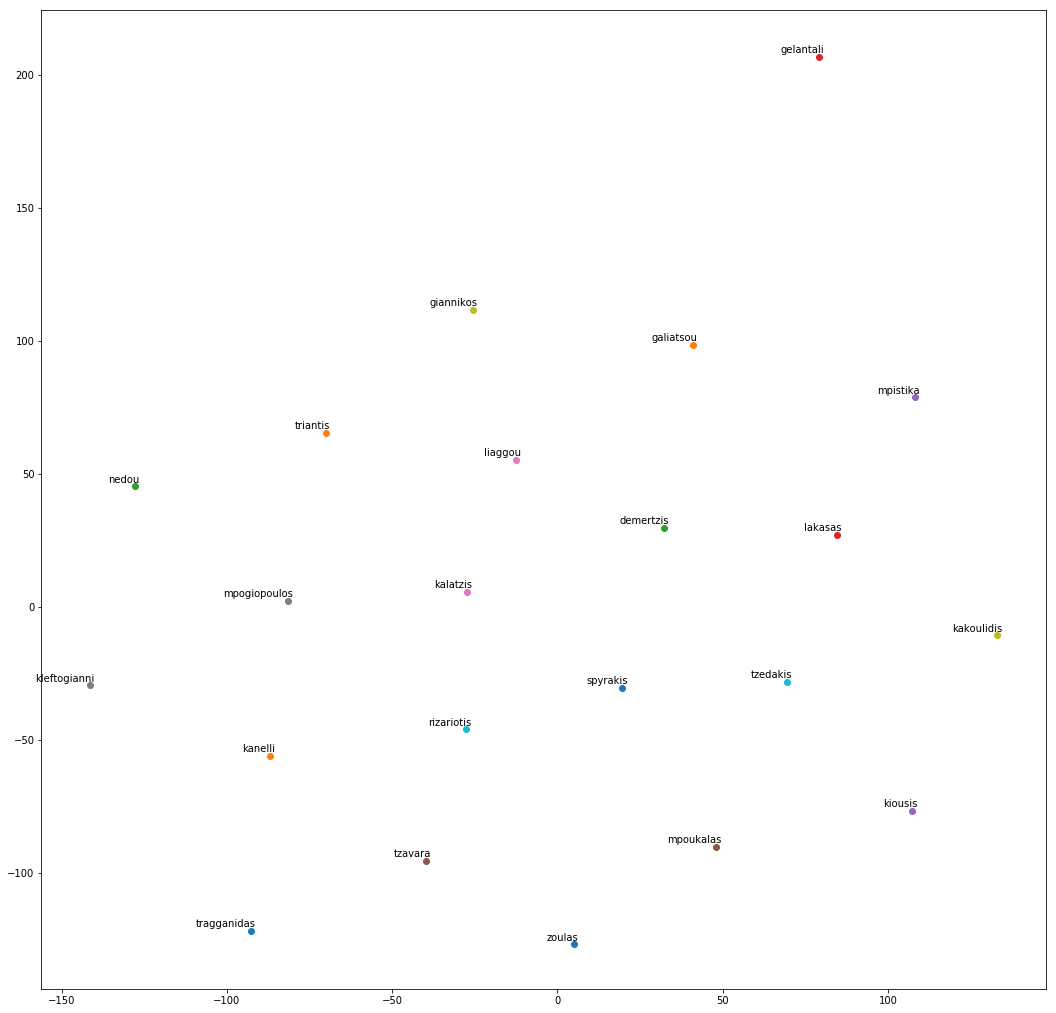

In [32]:
try:
    from sklearn.manifold import TSNE
    import matplotlib
    matplotlib.use('Agg')
    get_ipython().magic(u'matplotlib inline')
    get_ipython().magic(u'pylab inline')
    import matplotlib.pyplot as plt
    #
    final_embeddings = np.array( final_embeddings , dtype=float)
    # final_embeddings = np.array( final_embeddings , dtype=np.float64 )
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    # from final_embeddings, fit only author vectors
    to_fit = [final_embeddings[i, :] for i in authors.values()]
    low_dim_embs = tsne.fit_transform(to_fit)
    labels = [reverse_authors[i] for i in authors.values()]
    plot_with_labels(low_dim_embs, labels)
except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [28]:
with open('/home/user/project/embed-all-200.pickle', 'wb') as f:
    pickle.dump(final_embeddings, f) 

In [29]:
with open('/home/user/project/embed-all-200-author-only.pickle', 'wb') as f:
    pickle.dump(to_fit, f) 